# Marshmallow tech test
by Chung Lim (Anthony) 02/10/2020

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Data Exploration

In [2]:
# reading data files
prices = pd.read_csv('quote_prices.csv')
postcode_data = pd.read_csv('postcode_sector_data.csv')
authority_data = pd.read_csv('local_authority_data.csv')

# Use open source accident data from https://roadtraffic.dft.gov.uk/
accident_data = pd.read_csv('accident_data.csv')

In [3]:
# quick sense check of the data
prices.head()

,postcode,premium_price
0,B975BQ,324.58
1,UB33PN,3245.06
2,RH149XP,197.84
3,W130AG,1253.53
4,M145DT,514.05


In [4]:
postcode_data.head()

,postcode_sector,relative_area,population_density,multiple_deprivation_index,income_deprivation_index,employment_deprivation_index,crime_deprivation_index,rural_urban,distance_to_station,never_worked,region
0,AB101,1354.03,53.819802,16.748,0.105,0.091,-0.028,Large urban area,0.829961,Average,Scotland
1,AB106,458.99,86.465844,16.748,0.105,0.091,-0.028,Large urban area,1.609040,Average,Scotland
2,AB107,1053.10,55.795067,16.748,0.105,0.091,-0.028,Large urban area,2.899283,Average,Scotland
3,AB115,2317.54,60.742963,16.748,0.105,0.091,-0.028,Large urban area,0.773404,Average,Scotland
4,AB116,918.22,95.784434,16.748,0.105,0.091,-0.028,Large urban area,0.533438,Average,Scotland


In [5]:
authority_data.head()

,postcode_sector,road_usage,total_offences,vehicle_offences
0,DL11,566.0,12666.0,703.0
1,DL12,566.0,12666.0,703.0
2,DL13,566.0,12666.0,703.0
3,DL14,566.0,12666.0,703.0
4,DL15,566.0,12666.0,703.0


In [6]:
accident_data.head()

,Accident year,Region,Ons code,Urban rural,Road class,Light condition,Weather condition,All accidents
0,2015,North East,E12000001,Urban,A(M),Daylight,Fine no high winds,13
1,2015,North East,E12000001,Urban,A(M),Darkness - lights lit,Fine no high winds,11
2,2015,North East,E12000001,Urban,A(M),Darkness - lights lit,Raining + high winds,2
3,2015,North East,E12000001,Urban,A(M),Darkness - no lighting,Fine no high winds,1
4,2015,North East,E12000001,Urban,A(M),Darkness - lighting unknown,Fine no high winds,2


Firstly, let's start with *prices* dataset. 

In [7]:
# trim the postcode to postcode sector.
prices['postcode_sector'] = prices['postcode'].str[:-2]

# count number of duplicates in postcode sector
prices['postcode_sector'].duplicated().sum()

990814

As expected, there are some duplicates in *prices* data. Let's group those postcode sectors together and take the average prices. 

In [8]:
# group by postcode_sector in prices data
postcode_prices = prices.groupby(['postcode_sector']).mean().reset_index()

Moving on to *accident* data. This is download from gov website. It contains number of accidents in different regions from 2015 to 2019. We shall just use 2019 accident data for now since it is the latest we have.

In [9]:
# group by year and region to get total number of accidents.
accident_data = accident_data.groupby(['Accident year', 'Region']).sum().reset_index()

# Use the latest year 2019 data
accident_data = accident_data.loc[accident_data['Accident year'] == 2019, ['Region', 'All accidents']]
accident_data.rename(columns={'All accidents': 'total_accidents', 'Region': 'region'}, inplace=True)

In [10]:
# merge postcode dataset with accident data because there's a common key.
postcode_data = postcode_data.merge(accident_data)

Let's check *authority* data.

In [11]:
authority_data.dtypes

postcode_sector      object
road_usage           object
total_offences      float64
vehicle_offences    float64
dtype: object

Is *road_usage* an object or string?

In [12]:
# count values to show what's wrong with road_usage
authority_data['road_usage'].value_counts()[:10]

..        3258
1745.0     207
1287.0     131
4208.0     121
1997.0     118
553.0      114
4851.0     108
862.0       98
3563.0      96
1895.0      83
Name: road_usage, dtype: int64

Indeed, it's a mix object. Let's change *road_usage* into numerical because it is more useful.

In [13]:
# let's change that into NA values for now so we can change the datatype into float. We will treat missing values later.
authority_data.loc[authority_data['road_usage'] == '..', 'road_usage'] = np.nan
authority_data.loc[:, 'road_usage'] = authority_data['road_usage'].astype('float64')

All datasets look good and ready to be combine into one large dataframe. Let the fun begins!

In [14]:
# merge all 3 datasets together into a big dataframe.
df = postcode_prices.merge(postcode_data).merge(authority_data)

In [15]:
# check for missing values
df.isnull().sum()

postcode_sector                    0
premium_price                      0
relative_area                      0
population_density                 0
multiple_deprivation_index         0
income_deprivation_index           0
employment_deprivation_index       0
crime_deprivation_index            0
rural_urban                        0
distance_to_station                0
never_worked                       0
region                             0
total_accidents                    0
road_usage                      3113
total_offences                   832
vehicle_offences                 832
dtype: int64

There are some missing values in the final dataframe, but that's okay. We have 2 choices here:
1. we can remove them and forget about them. (not the best)
2. we can use some imputation techniques to fill in the blanks. (let's try this)

In [16]:
# make sure dtype for all columns make sense
df.dtypes

postcode_sector                  object
premium_price                   float64
relative_area                   float64
population_density              float64
multiple_deprivation_index      float64
income_deprivation_index        float64
employment_deprivation_index    float64
crime_deprivation_index         float64
rural_urban                      object
distance_to_station             float64
never_worked                     object
region                           object
total_accidents                   int64
road_usage                      float64
total_offences                  float64
vehicle_offences                float64
dtype: object

Text(0.5, 0, 'road usage')

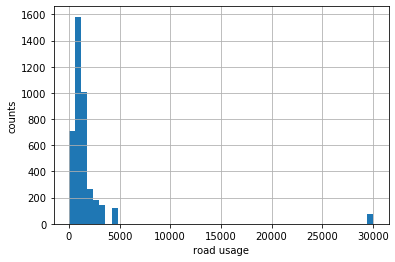

In [17]:
# plot histogram for road usage
df['road_usage'].hist(bins=50)
plt.ylabel('counts')
plt.xlabel('road usage')

Text(0.5, 0, 'premium price')

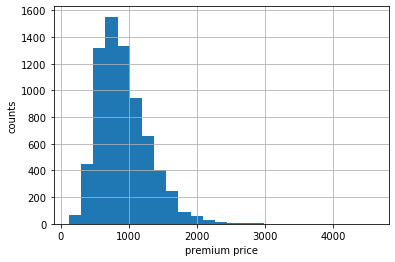

In [18]:
# plot histogram for premium prices
df['premium_price'].hist(bins=25)
plt.ylabel('counts')
plt.xlabel('premium price')

It is a skewed distribution with a long tail. This is expected because some premiums are just very high! The distribution shouldn't our further analysis but it is good to know.

In [19]:
# check for any potential correlation with premium prices
df.corr()

,premium_price,relative_area,population_density,multiple_deprivation_index,income_deprivation_index,employment_deprivation_index,crime_deprivation_index,distance_to_station,total_accidents,road_usage,total_offences,vehicle_offences
premium_price,1.000000,-0.260743,0.323083,0.485858,0.476445,0.403787,0.496826,-0.273117,0.215293,-0.120473,0.326986,0.385635
relative_area,-0.260743,1.000000,-0.274932,-0.179443,-0.230823,-0.210289,-0.284915,0.529433,-0.220070,0.135035,-0.191235,-0.232089
population_density,0.323083,-0.274932,1.000000,0.262289,0.270248,0.184088,0.372446,-0.284833,0.355646,-0.119724,0.264317,0.309377
multiple_deprivation_index,0.485858,-0.179443,0.262289,1.000000,0.968844,0.949995,0.717229,-0.177262,-0.048281,-0.073595,0.358721,0.290754
income_deprivation_index,0.476445,-0.230823,0.270248,0.968844,1.000000,0.967447,0.673442,-0.206737,-0.017852,-0.083907,0.324491,0.289546
employment_deprivation_index,0.403787,-0.210289,0.184088,0.949995,0.967447,1.000000,0.597311,-0.170333,-0.137753,-0.069377,0.265501,0.186337
crime_deprivation_index,0.496826,-0.284915,0.372446,0.717229,0.673442,0.597311,1.000000,-0.327065,0.200618,-0.085151,0.364330,0.388658
distance_to_station,-0.273117,0.529433,-0.284833,-0.177262,-0.206737,-0.170333,-0.327065,1.000000,-0.292943,0.143848,-0.189245,-0.248066
total_accidents,0.215293,-0.220070,0.355646,-0.048281,-0.017852,-0.137753,0.200618,-0.292943,1.000000,-0.130150,0.064824,0.297079
road_usage,-0.120473,0.135035,-0.119724,-0.073595,-0.083907,-0.069377,-0.085151,0.143848,-0.130150,1.000000,0.105643,0.030812


From above, we can see that premium prices are related to deprivation indexes such as crime, income, employment, etc... It also has some weaker correlations with other factors as well. 

Interesting observation is that some factors are also correlated with each other. This is important because **multicollinearity** within the features will affect our further analysis or model.

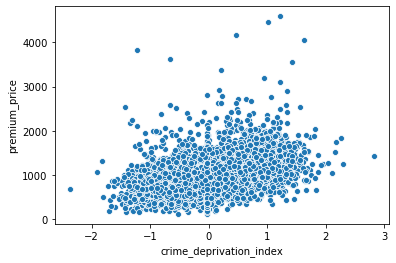

In [20]:
# plot premium prices against crime deprivation index
sns.scatterplot(data=df, x='crime_deprivation_index', y='premium_price')

The figure above show some positive trend between *premium_price* and *crime_deprivation_index*. Also, we see lots of noise in the data!

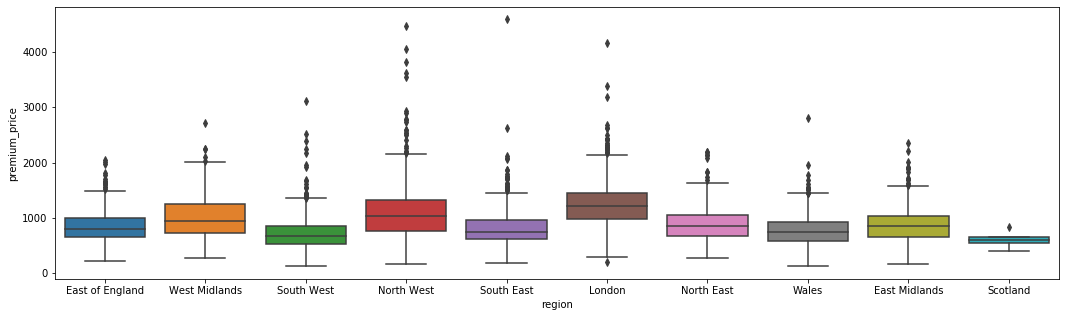

In [21]:
# plot premium prices in region.
plt.figure(figsize=(18,5))
sns.boxplot(data=df, x='region', y='premium_price')

There are some price variations across different regions which show that region can be a predictive feature. Some outliers can also be observed.

With these observations in mind, let's move on to modelling!

## Data preparation

We will assume that *postcode_sector* has minimal predictive power because it is just an unique identifier in this case. We will drop it.

In [22]:
# drop postcode_sector
df.drop(['postcode_sector'], axis=1, inplace=True)

In [23]:
# Encode categorical data into numerical
df = pd.get_dummies(df)

## Regression models

In [24]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

import scipy.stats as stats

In [25]:
# define a function to evaluate model.
def evaluate(model, X_train, y_train, X_test, y_test):
    # Evaluate regression model using R2 for goodness of fit and MSE for test validation.
    print(f'R2: {model.score(X_train, y_train)}')
    
    y_pred = model.predict(X_test)
    print(f'MSE: {mean_squared_error(y_test, y_pred)}')
    
    # plot actual against predicted.
    sns.regplot(x=y_test, y=y_pred)
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.show()
    
    # plot qq plot of residual.
    residuals = y_test - y_pred
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.show()

In [26]:
# split data into features and target
X = df.drop(['premium_price'], axis=1)
y = df['premium_price']

In [27]:
# split data into train and test
train_test_ratio = 0.75
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_test_ratio, test_size=1-train_test_ratio)

### Baseline model
Let's set up a baseline model by taking the mean value of the target. We will compare our regression models against this baseline. Hopefully, they will do better than this dummy model.

R2: 0.0
MSE: 153401.68285265556


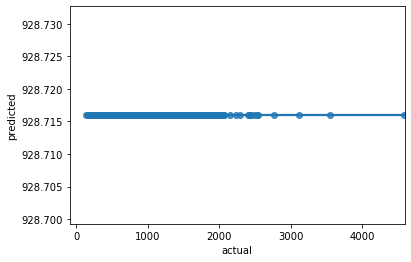

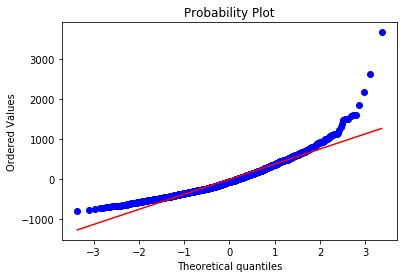

In [28]:
baseline = make_pipeline(DummyRegressor())
baseline.fit(X_train, y_train)
evaluate(baseline, X_train, y_train, X_test, y_test)

### ElasticNet Linear Regression
This regression technique applies l1 and l2 regularization to the model in order to reduce the effect of multicollinearity. In this case study, we will include several steps in the modelling:
1. Apply mean imputation to all numerical data points that are missing - SimpleImputer()
2. Scale the data - StandardScaler()
3. Fit data to the model - ElasticNet()

R2: 0.38224827500818326
MSE: 98481.09057616653


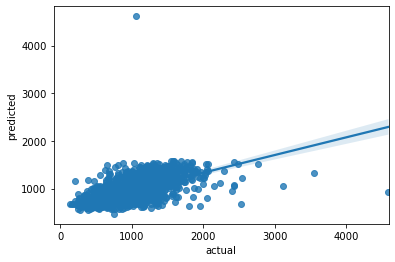

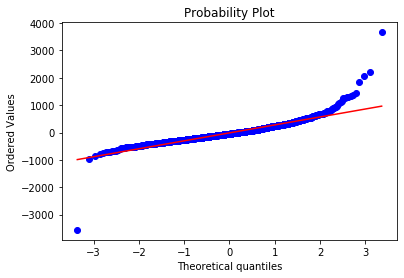

In [29]:
# make a pipeline for the model.
LR = make_pipeline(SimpleImputer(), StandardScaler(), ElasticNet(alpha=0.9, l1_ratio=0.7, random_state=1234))

# fit the data to the model
LR.fit(X_train, y_train)

# evalutate the model
evaluate(LR, X_train, y_train, X_test, y_test)

In [30]:
# display the coefficients for the LR model.
coeff = list(zip(X_train.columns, abs(LR.steps[-1][1].coef_)))
coeff = sorted(coeff, key=lambda x:x[1], reverse=True)

In [31]:
# top 5 factors
coeff[:5]

[('crime_deprivation_index', 47.75576672580031),
 ('multiple_deprivation_index', 42.14121207935815),
 ('population_density', 41.80033753322178),
 ('rural_urban_Urban major conurbation', 30.653346032312104),
 ('vehicle_offences', 30.636044207222163)]

In [32]:
# bottom 5 factors
coeff[-5:]

[('rural_urban_Other urban area', 0.0),
 ('rural_urban_Rural hamlet and isolated dwellings in a sparse setting', 0.0),
 ('rural_urban_Urban minor conurbation', 0.0),
 ("rural_urban_['Rural hamlet and isolated dwellings in a sparse setting'\n 'Rural village in a sparse setting']",
  0.0),
 ("rural_urban_['Rural hamlet and isolated dwellings' 'Urban major conurbation']",
  0.0)]

### Support Vector Regressor
This regression technique will help to explore any high dimesional relationships/correlations between the features and the target. The steps used here are very similar to the above linear regression model.

R2: 0.36504638349534657
MSE: 92765.78085733078


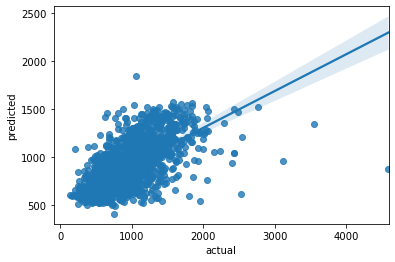

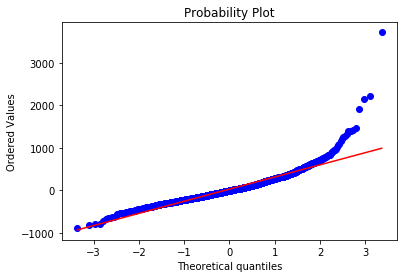

In [33]:
SV = make_pipeline(SimpleImputer(), MinMaxScaler(), SVR(C=500, gamma=0.01))
SV.fit(X_train, y_train)
evaluate(SV, X_train, y_train, X_test, y_test)

## Evaluation

We have cleaned the data and applied some imputation to missing numerical values. We proceeded to perform regression analysis.

First and foremost, both ElasticNet and Support Vector machines outperformed our baseline model. However, there are some concerns with the models we created. 

The R2 for the ElasticNet model is not great. This shows that this model did not fit very well to the training data. The residual qq-plot clearly shows that it violates the main assumption of normally distributed residual. This leads us to try non-linear model.

The R2 for the support vector regression is still not great, but the mean square error (MSE) is better than ElasticNet.

There are clearly plenty of room for improvements. Further steps can include (ordered in highest priority):
1. Run statistical tests like F-test to check the overall significance of the regression model.
2. Hyperparameter tunning.
3. Reduce outliers and noises in the data. 
4. Feature engineering (get more features - such as accident by postcode sector) and extraction (such as PCA).